In [ ]:
DATA_NAME = "lastfm"
MODEL_NAME = f"NCF_{DATA_NAME}"
LEARNING_TYPE = "pointwise"
TRN_NEG_PER_POS = 4
TRN_BATCH_SIZE = 128

# WORK_DIR_PATH = "../.."

from google.colab import drive
drive.mount('/content/drive')
WORK_DIR_PATH = "/content/drive/MyDrive/RS-NeuMF/"

Mounted at /content/drive


# Constants

In [ ]:
# split
EVAL_NEG_PER_POS = 99
EVAL_BATCH_SIZE = 1000
DATA_LOADING_TYPE = "general"
FILTER_BY = "user"
TRN_VAL_TST_RATIO = [0.8, 0.1, 0.1]
NEG_PER_POS = [TRN_NEG_PER_POS, TRN_NEG_PER_POS, EVAL_NEG_PER_POS, EVAL_NEG_PER_POS]
BATCH_SIZE = [TRN_BATCH_SIZE, TRN_BATCH_SIZE, EVAL_BATCH_SIZE, EVAL_BATCH_SIZE]
MAX_HIST = None
SHUFFLE = False if DATA_LOADING_TYPE=="curriculum" else True

# Model
N_FACTORS = 32
HIDDEN = [N_FACTORS*2, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
DROPOUT = 0.2

# how to learn
LEARNING_RATE = 1e-4
LAMBDA_ = 1e-2

# how to monitor
PATIENCE = 10
MIN_DELTA = 1e-3

# how to loop
N_EPOCHS = 1000
INTERVAL = 10

# Config

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: /content/drive/MyDrive/RS-NeuMF


In [10]:
import pandas as pd
import torch
from NeuMF import neumf
import UTILS
from LOOP.loop import TrainingLoop
from LOOP.monitor.predictor import predict
from LOOP.monitor.monitor import EarlyStoppingMonitor
from LOOP.metric.ranking import ndcg_at_k as metric_fn
from LOOP.metric.ranking import top_k_loop

In [ ]:
if LEARNING_TYPE=="pairwise":
    from DATA_SPLITTER.pairwise import trn_val_tst
    from LOOP.trainer.pairwise import PairwiseTrainer as Trainer
    from LOOP.loss_fn.bpr import bpr as task_fn

elif LEARNING_TYPE=="pointwise":
    from DATA_SPLITTER.pointwise import trn_val_tst
    from LOOP.trainer.pointwise import PointwiseTrainer as Trainer
    from LOOP.loss_fn.bce import bce as task_fn

else:
    ValueError

In [12]:
from UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [13]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [14]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [ ]:
data = pd.read_csv(f"./_data/{DATA_NAME}.csv")

In [18]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [19]:
# data Description
UTILS.data_handler.description(data)

number of user: 1892
number of item: 17632
total interaction: 92834
interaction density: 0.2783 %
max interaction of user: 50
top 10.0 % interaction of user: 50.0
mean interaction of user: 49
mean interaction of item: 5


In [20]:
kwargs = dict(
    origin=data,
    n_users=N_USERS,
    n_items=N_ITEMS,
    loading_type=DATA_LOADING_TYPE,
)

dataloader = trn_val_tst.DataSplitter(**kwargs)

In [21]:
kwargs = dict(
    filter_by=FILTER_BY,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS,
    batch_size=BATCH_SIZE,
    max_hist=MAX_HIST,
    shuffle=SHUFFLE,
)

loaders, interactions, histories = dataloader.get(**kwargs)

In [22]:
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [23]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    hidden=HIDDEN,
    dropout=DROPOUT,
)

model = neumf.ncf.Module(**kwargs)

In [24]:
kwargs = dict(
    model=model,
    task_fn=task_fn,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_
)

trainer = Trainer(**kwargs)

In [25]:
kwargs = dict(
    model=model,
    metric_fn=metric_fn,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

monitor = EarlyStoppingMonitor(**kwargs)

In [26]:
kwargs = dict(
    model=model,
    trainer=trainer,
    monitor=monitor,
)

loop = TrainingLoop(**kwargs)

# Train

In [27]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    loo_loader=loo_loader,
    n_epochs=N_EPOCHS,
    interval=INTERVAL,
)

history = loop.fit(**kwargs)

LEAVE ONE OUT BEST EPOCH: 240
LEAVE ONE OUT BEST SCORE (ndcg@10): 0.5680
MEAN OF PER EPOCH (/s): 13.6074


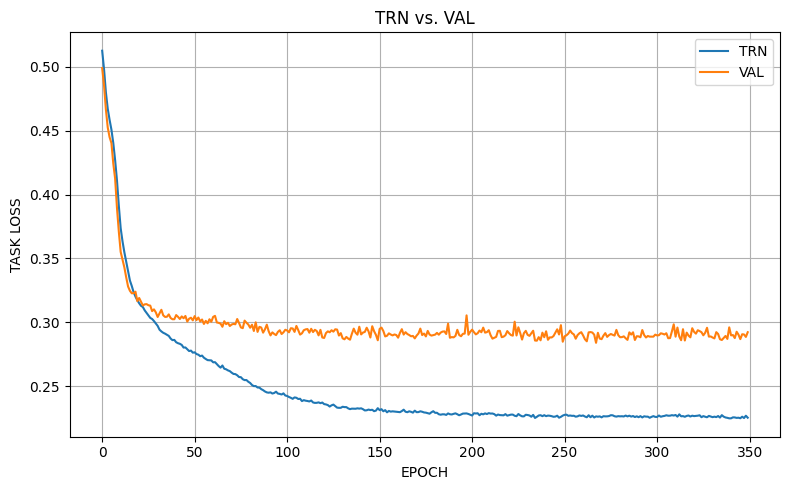

In [28]:
UTILS.visualizer.loss_plot(history, 'TASK LOSS')

# Test

In [29]:
kwargs = dict(
    model=model,
    dataloader=tst_loader,
)

result = predict(**kwargs)

TST: 100%|██████████| 9274/9274 [00:10<00:00, 865.45it/s]


In [30]:
eval = top_k_loop(result)
eval

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.872601,0.350853,0.356272,0.271907,0.393648
1,10,0.936567,0.251226,0.509311,0.332154,0.477672
2,15,0.957356,0.193497,0.587500,0.352632,0.512848
3,20,0.964819,0.156050,0.631521,0.361343,0.530426
4,25,0.971215,0.131386,0.664730,0.366591,0.542663
5,50,0.985075,0.073774,0.746642,0.375521,0.569377
6,100,0.994670,0.040032,0.811238,0.378966,0.586876


# Save

In [ ]:
PATH = f'./_checkpoints/{LEARNING_TYPE}_{INTERVAL}_{TRN_BATCH_SIZE}_{TRN_NEG_PER_POS}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)